In [1]:
from collections import OrderedDict
import os
import json
import subprocess

from albumentations import Compose, ShiftScaleRotate, HorizontalFlip, RandomBrightnessContrast, RandomResizedCrop, VerticalFlip, Rotate
from albumentations.pytorch import ToTensor

import cv2
from joblib import Parallel, delayed 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.models as models
import torchvision.transforms as transforms

In [3]:
%matplotlib inline

In [4]:
# Global variables:
DATA_BASE_PATH = '../data/'
PNG_DIR = 'png_256/'
IMG_SIZE = 256

Check GPU:

In [5]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA capable device available!")

Device 0: GeForce RTX 2080 Ti


## Load CSVs

In [6]:
#os.listdir(DATA_BASE_PATH + PNG_DIR)

In [7]:
train_img_stats = pd.read_csv(DATA_BASE_PATH + PNG_DIR + 'train_img_stats.csv')
train_img_stats = train_img_stats.set_index('filename')
#train_img_stats.head()

In [8]:
print(
    "In the training set there are...\n"
    "{} images corresponding to \n"
    "{} studies, \n"
    "{} series, and \n"
    "{} patients.".format(
        train_img_stats.shape[0],
        train_img_stats['study_instance_ID'].unique().size,
        train_img_stats['series_instance_ID'].unique().size,
        train_img_stats['patient_ID'].unique().size)
)

In the training set there are...
752802 images corresponding to 
21744 studies, 
21744 series, and 
18938 patients.


In [9]:
pivot_df = pd.read_csv(DATA_BASE_PATH + PNG_DIR + 'pivot_df.csv')
del pivot_df['Unnamed: 0']
pivot_df = pivot_df.set_index('filename')
#pivot_df.head()

In [10]:
print(train_img_stats.shape)
print(pivot_df.shape)

(752802, 30)
(752802, 6)


In [11]:
train_df = train_img_stats.join(pivot_df)
train_df.shape

(752802, 36)

Count the number of images in the training dataset for each type of intracranial hemorrhage (as well as "any").

In [12]:
pivot_df.describe().loc['mean', :] * pivot_df.shape[0]

any                 107933.0
epidural              3145.0
intraparenchymal     36118.0
intraventricular     26205.0
subarachnoid         35675.0
subdural             47166.0
Name: mean, dtype: float64

## Visualize some images

As part of the preprocessing the following steps were performed:

0. The "slope" and "intecept" values from the DICOM header are applied.
1. The images are cropped around the head.
2. Small crops are padded to at least a size of 224-by-224 pixels.
3. All images are resized to 256-by-256 pixels.

The images were transformed to RGB and save in PNG format, where the 8-bit channels contain the following:

- RED: 0-255 HU range;
- GREEN (something like a subdural window): window center $=$ 100, window width $=$ 255;
- BLUE (something like a soft tissue window): window center $=$ 40, window width $=$ 380;

### Epidural

In [13]:
img_names = train_df[train_df.epidural == 1].index.values[:25]

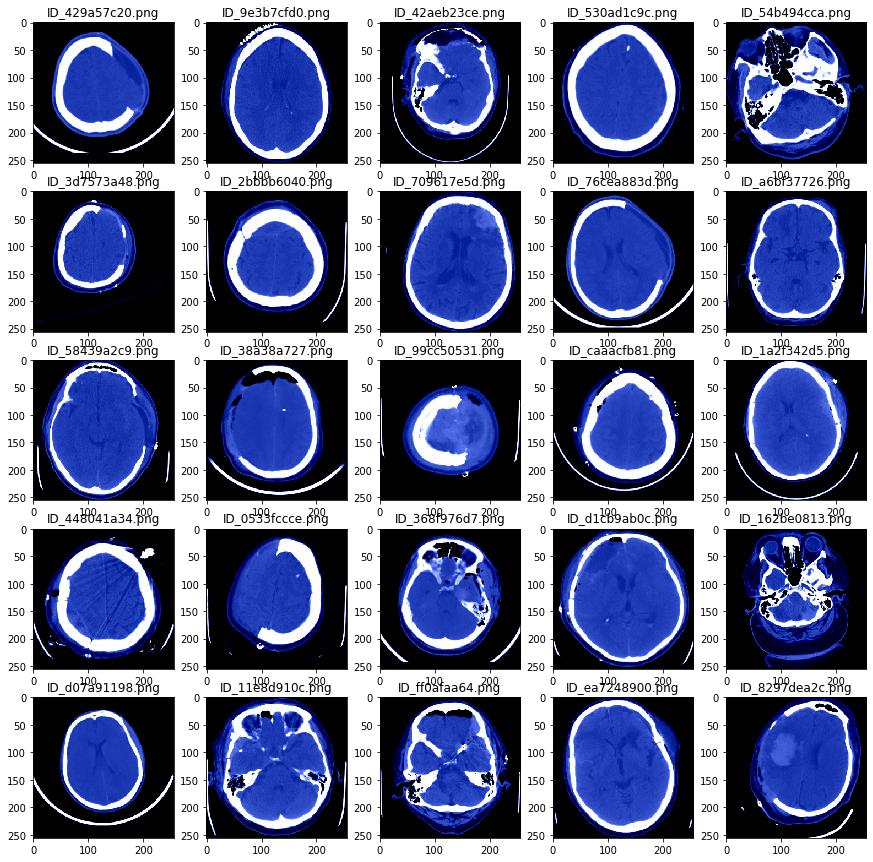

In [14]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
ind = 0
for i in range(5):
    for j in range(5):
        x = cv2.imread(DATA_BASE_PATH + PNG_DIR + "train/" + img_names[ind])
        x = Image.fromarray(x)
        axs[i, j].imshow(x)
        axs[i, j].set_title(img_names[ind])
        ind += 1

### Intraparenchymal

In [15]:
img_names = train_df[train_df.intraparenchymal == 1].index.values[:25]

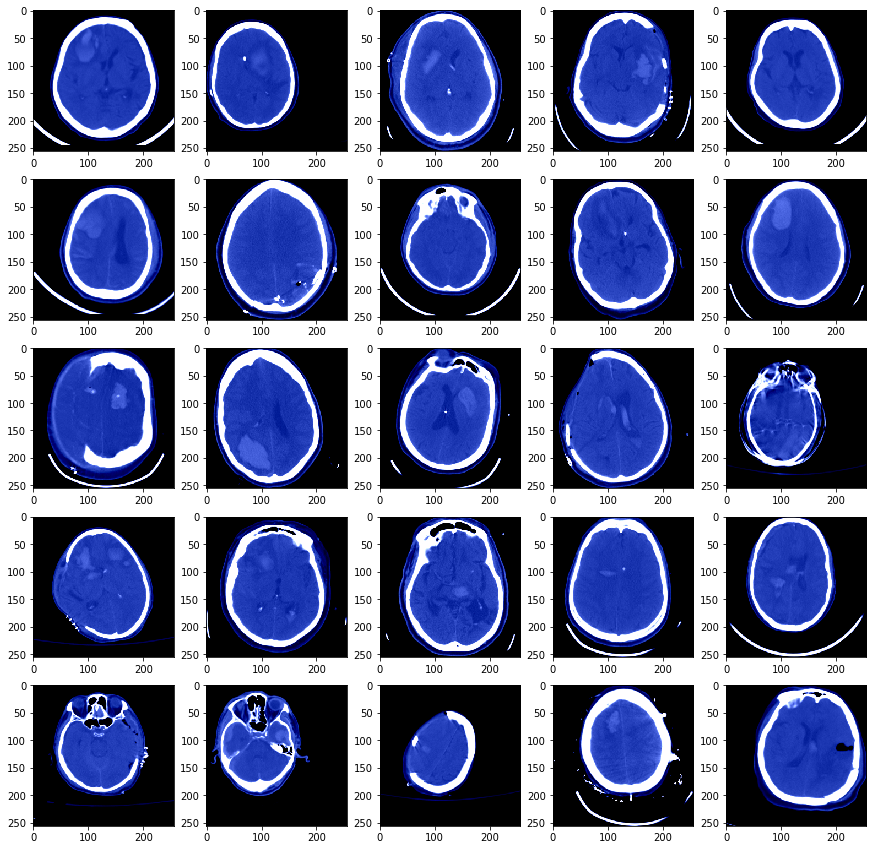

In [16]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
ind = 0
for i in range(5):
    for j in range(5):
        x = cv2.imread(DATA_BASE_PATH + PNG_DIR + "train/" + img_names[ind])
        ind += 1
        x = Image.fromarray(x)
        axs[i, j].imshow(x)

### Intraventricular

In [17]:
img_names = train_df[train_df.intraventricular == 1].index.values[:25]

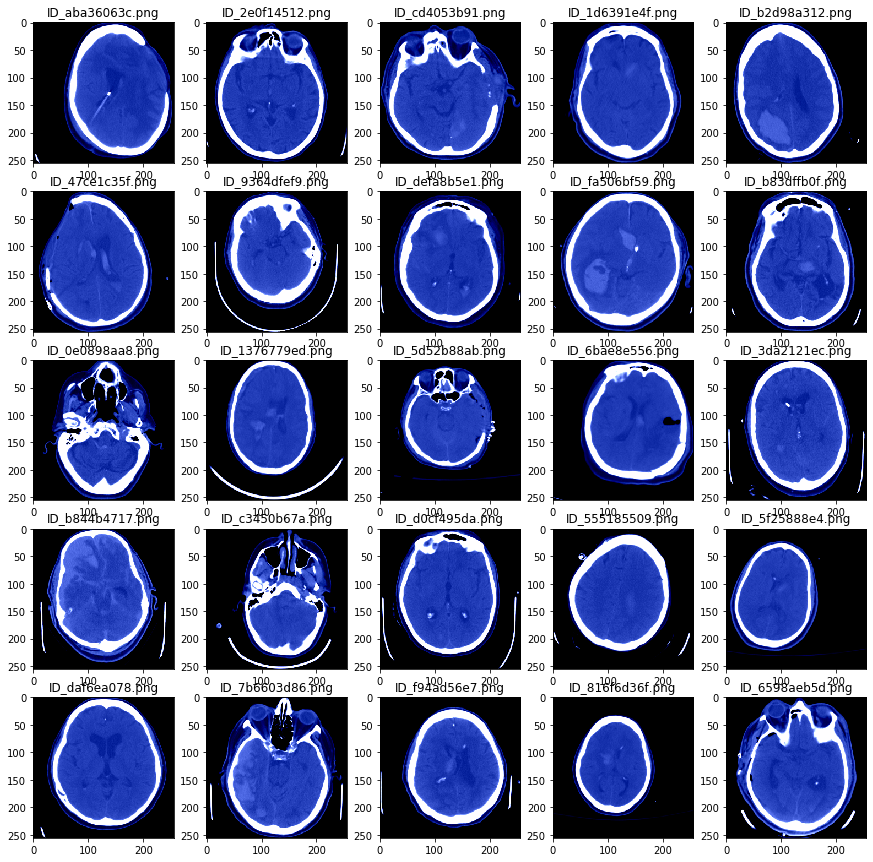

In [18]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
ind = 0
for i in range(5):
    for j in range(5):
        x = cv2.imread(DATA_BASE_PATH + PNG_DIR + "train/" + img_names[ind])
        x = Image.fromarray(x)
        axs[i, j].imshow(x)
        axs[i, j].set_title(img_names[ind])
        ind += 1

### Subarachnoid

In [19]:
img_names = train_df[train_df.subarachnoid == 1].index.values[:25]

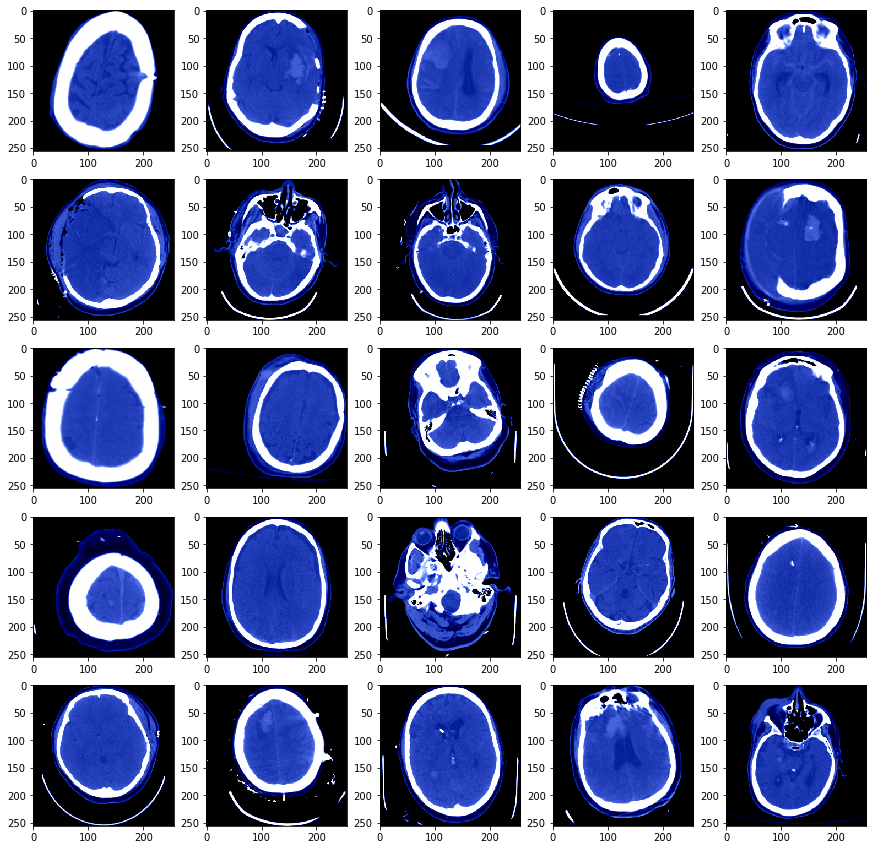

In [20]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
ind = 0
for i in range(5):
    for j in range(5):
        x = cv2.imread(DATA_BASE_PATH + PNG_DIR + "train/" + img_names[ind])
        ind += 1
        x = Image.fromarray(x)
        axs[i, j].imshow(x)

### Subdural

In [21]:
img_names = train_df[train_df.subdural == 1].index.values[:25]

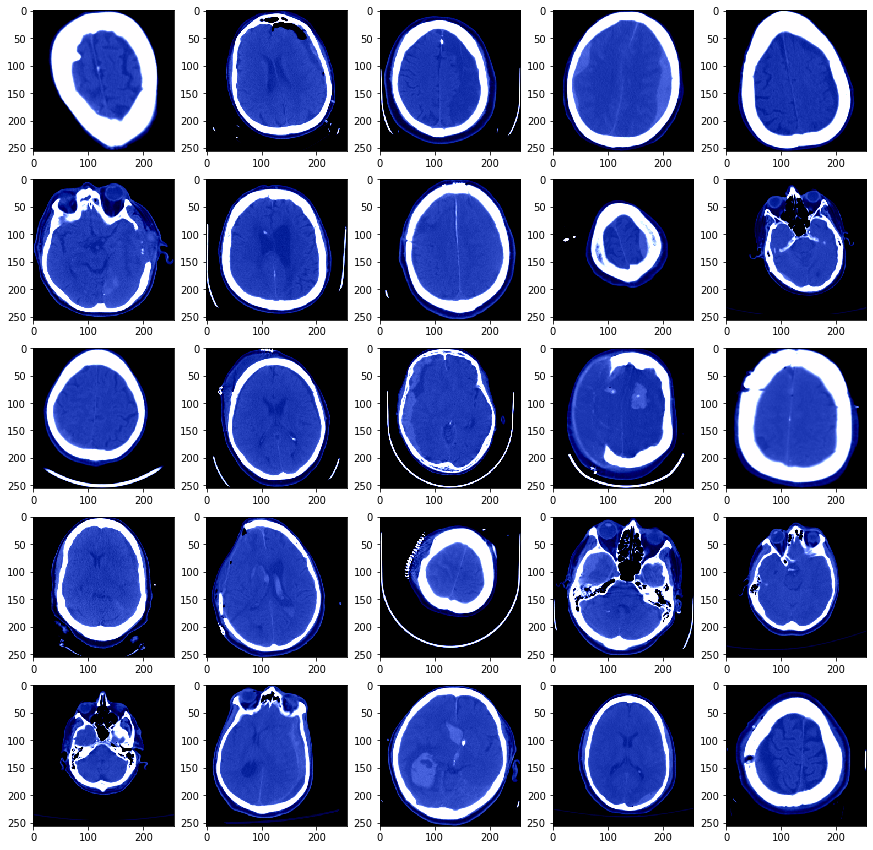

In [22]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
ind = 0
for i in range(5):
    for j in range(5):
        x = cv2.imread(DATA_BASE_PATH + PNG_DIR + "train/" + img_names[ind])
        ind += 1
        x = Image.fromarray(x)
        axs[i, j].imshow(x)

### Normal

In [23]:
img_names = train_df[train_df['any'] == 0].index.values[:25]

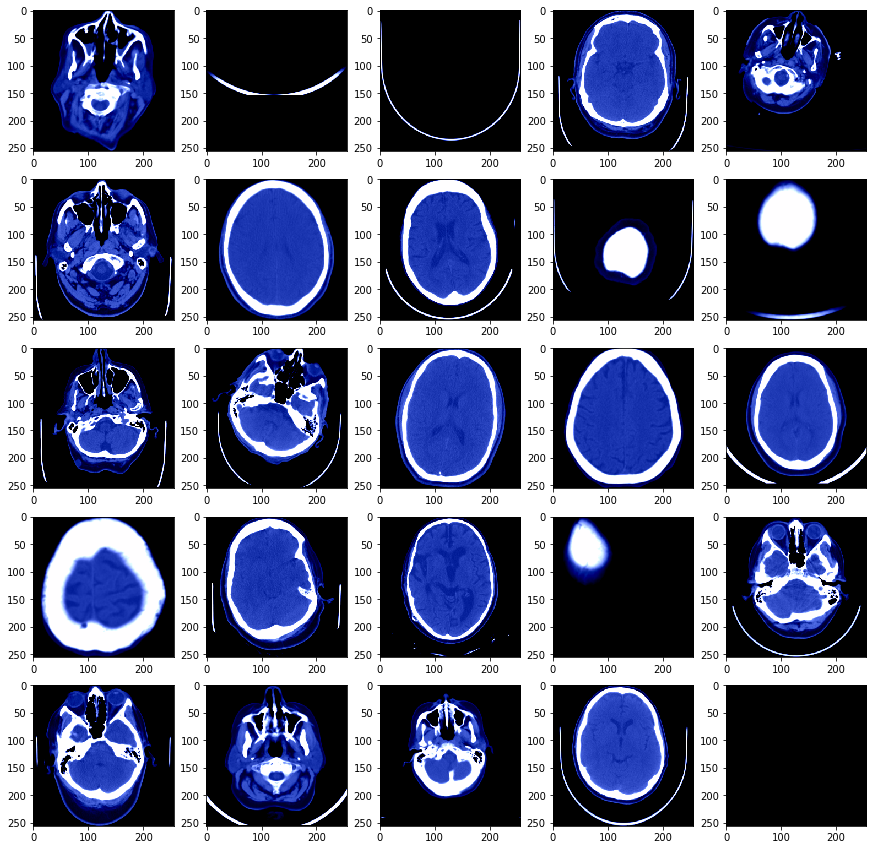

In [24]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
ind = 0
for i in range(5):
    for j in range(5):
        x = cv2.imread(DATA_BASE_PATH + PNG_DIR + "train/" + img_names[ind])
        ind += 1
        x = Image.fromarray(x)
        axs[i, j].imshow(x)

### "Suspicious" images

There is a small number of images which are stored in an unsigned integer format (i.e., only non-negative values) but have "intercept" set to zero in the DICOM header (or very close to zero). Upon closed inspection it seems that the storage format was incorrectly specified as unsigned integer, and there is some overflow whereby negative values appear as large positive values. I tried to correct this in my preprocessing (based on the comment by Malcolm McLean under the Kaggle notebook some-dicom-gotchas-to-be-aware-of-fastai by Jeremy Howard at kaggle.com). Some resulting preprocessed images are given below.

In [25]:
suspicious = (train_df["pixel_representation"] == 0) & (train_df["intercept"] > -2)
img_names = train_df[suspicious].index.values[:25]

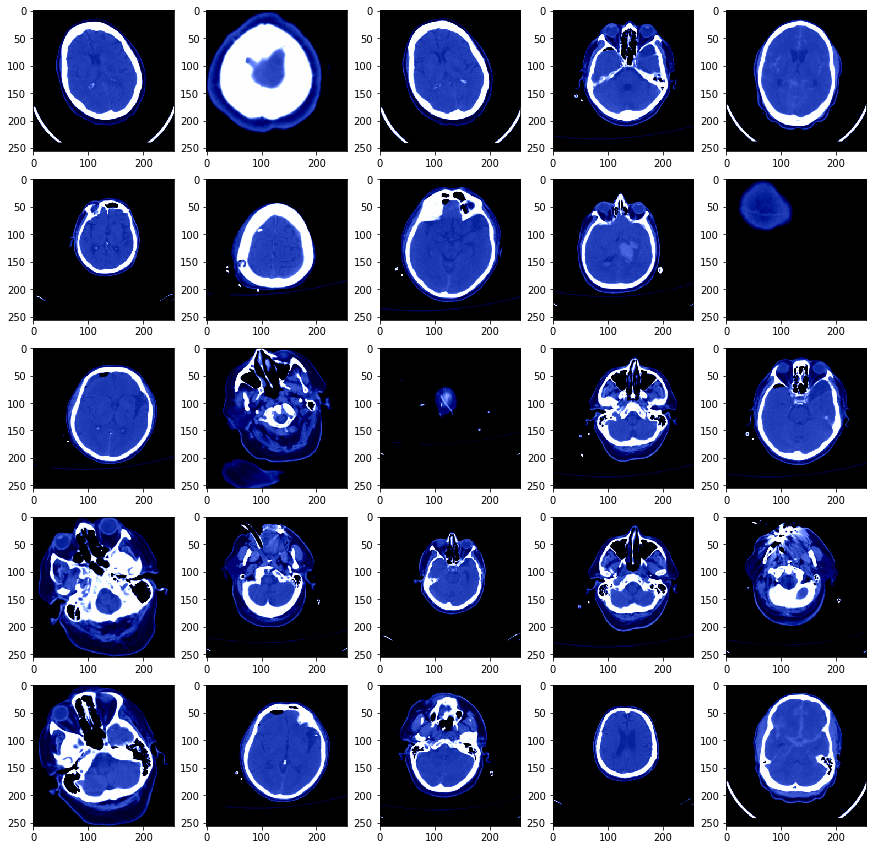

In [26]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
ind = 0
for i in range(5):
    for j in range(5):
        x = cv2.imread(DATA_BASE_PATH + PNG_DIR + "train/" + img_names[ind])
        ind += 1
        x = Image.fromarray(x)
        axs[i, j].imshow(x)

## Image augmentation

We observe visually what different typoes of image transformations result in when applied to these data.

I use the following transformations:

- `HorizontalFlip(p=0.5)`
- `VerticalFlip(p=0.5)`
- `RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=0.5)`
- `ShiftScaleRotate(border_mode=0)`

In [27]:
transform_train = Compose([
    #RandomResizedCrop(height=IMG_SIZE, width=IMG_SIZE,
    #                  scale=(0.8, 1.0), p=0.7),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomBrightnessContrast(brightness_limit=0.08,
                             contrast_limit=0.08, p=0.5),
    ShiftScaleRotate(border_mode=0),
    #Rotate(limit=30, border_mode=0, p=0.7)
])

In [28]:
np.random.seed(2019)
img_names = train_img_stats.index.values
np.random.shuffle(img_names)
img_names = img_names[:25]

#### Without transform:

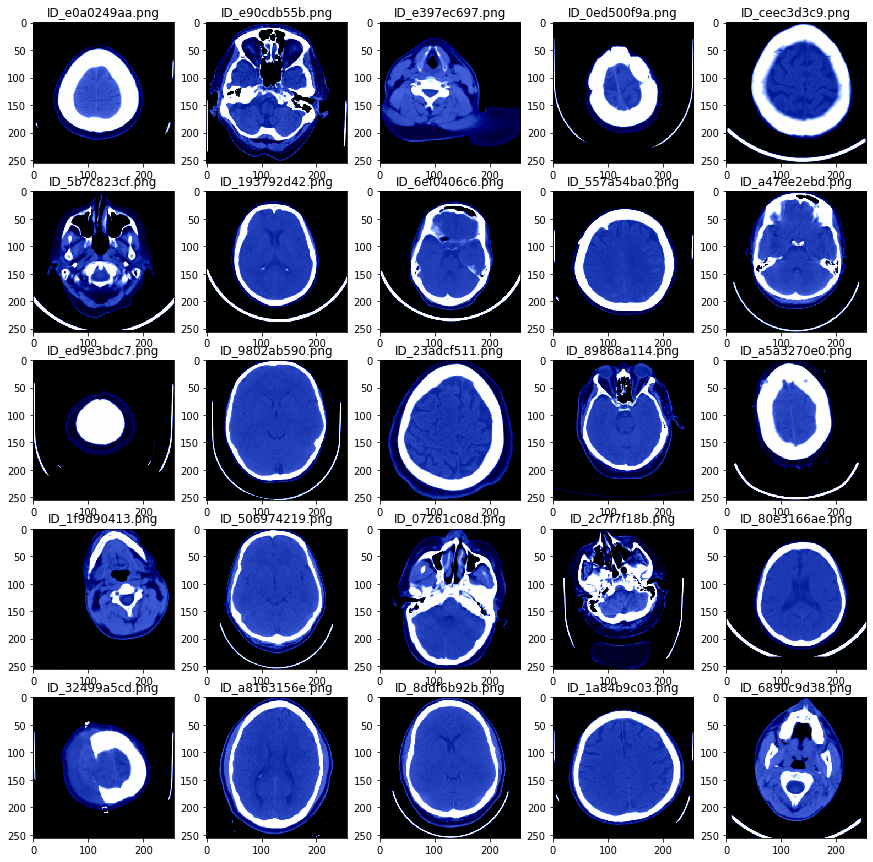

In [29]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
ind = 0
for i in range(5):
    for j in range(5):
        x = cv2.imread(DATA_BASE_PATH + PNG_DIR + "train/" + img_names[ind])
        x = Image.fromarray(x)
        axs[i, j].imshow(x)
        axs[i, j].set_title(img_names[ind])
        ind += 1

#### Same images with transform:

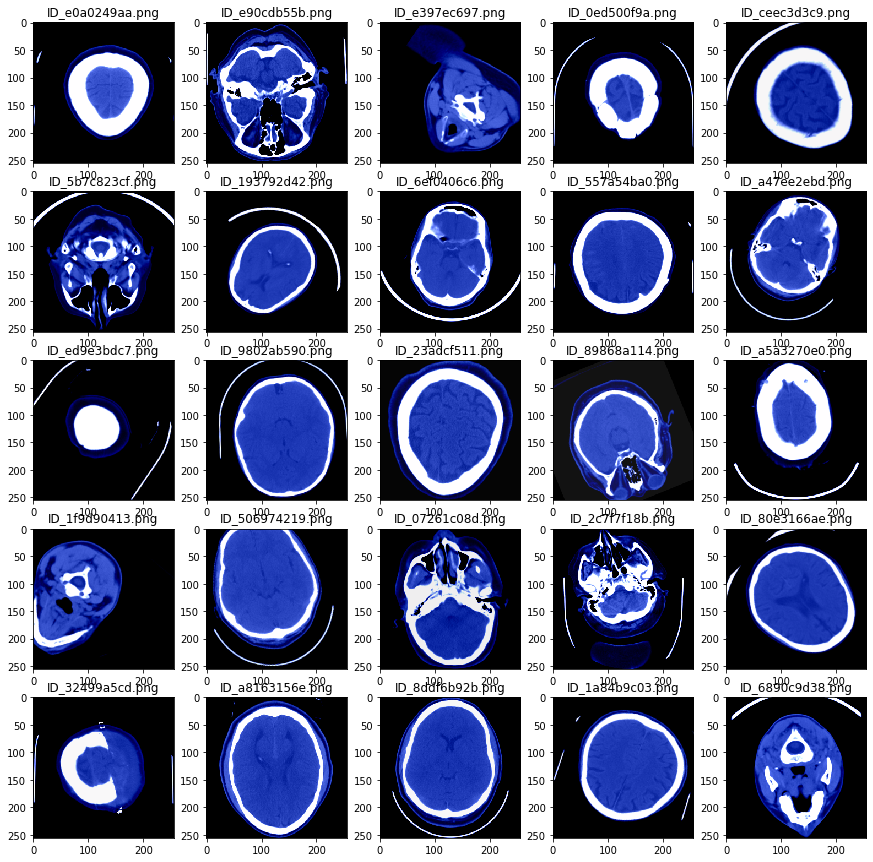

In [30]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
ind = 0
for i in range(5):
    for j in range(5):
        x = cv2.imread(DATA_BASE_PATH + PNG_DIR + "train/" + img_names[ind])
        x = transform_train(image=x)['image']
        #x = Image.fromarray(x)
        axs[i, j].imshow(x)
        axs[i, j].set_title(img_names[ind])
        ind += 1